# 201601615 이의찬

# 1. 지정 주제

## 영화: 외계+인 1부
치밀한 내용, 아쉬운 cg
기술적인 이유는 이 영화는 사람들의 호불호가 갈리고 의견의 대립이 첨예하기 때문이다.<br>
<br>
또한 적절한 데이터 수이다. <br>
원래 '인터스텔라'를 선정하였으나 5000개가 넘는 너무 많은 데이터와 <br>
데이터의 평점이 너무 높고 뒤로 갈수록 댓글 또한 적어서 극적인 긍정과 부정의 차이를 보기 힘들었다.<br>
<br>
이러한 이유로 '외계+인 1부'를 선정하게 되었다.

In [267]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By # find_element 를 할 때, 속성값 관리
from urllib.request import urlopen
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Okt
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import urllib
import time

okt = Okt()

POS = 9
NEG = 4

In [268]:
driver_path = "chromedriver.exe" # 경로명: 현재 폴더로 되어있음
movie_url = r"https://movie.daum.net/moviedb/grade?movieId=139606" # 영화: 위플래쉬

### selenium 드라이버

In [269]:
driver = webdriver.Chrome(driver_path)
driver.implicitly_wait(3) # 열리는 시간 3초 대기
driver.get(movie_url)
time.sleep(2)

C:\Users\outda\AppData\Local\Temp\ipykernel_16252\1645013352.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(driver_path)


## 1. 영화 리뷰 가져오기

In [270]:
user_count = driver.find_element(
    By.CLASS_NAME, "txt_netizen"
).text.strip("()명") # 평점을 남긴 네티즌 수

more_count = (int(user_count) - 10) // 30 + 1 # more 버튼 누르는 총 횟수

more_button = '//*[@id="alex-area"]/div/div/div/div[3]/div[1]/button' # 더보기 버튼

for i in tqdm(range(more_count)):
    driver.find_element("xpath", more_button).click()
    time.sleep(2)

  0%|          | 0/53 [00:00<?, ?it/s]

In [271]:
# html 텍스트 파일 저장 코드
html = driver.page_source
text_file = open('whiplash_review_data.txt', 'w', encoding='utf-8')
text_file.write(html)
text_file.close()

#### driver.page_source 사용 이유

```python
html = urlopen(movie_url)
soup = BeautifulSoup(html.read(), "html.parser")
```

`BeautifulSoup`을 사용할 경우 모든 태그를 가져오지 않는다.(::after로 숨겨져 있음) <br>
`driver.page_source`를 사용하여 현재 렌더링 된 페이지의 모든 `Elements`를 모두 가져오고 selenium으로 작업한 url 정보를 html로 가져온다. <br>


In [272]:
# html = driver.page_source # selenium으로 작업한 url 정보를 html로 가져옴
with open('whiplash_review_data.txt', 'r', encoding='utf-8') as f:
    html = f.read()
    f.close()

soup = BeautifulSoup(html, "html.parser")

div_reviews = soup.find_all("div", {"class": "cmt_info"})

reviews = [] # list<<tuple(str, int)>>

for review in tqdm(div_reviews):
    comment = review.find("p", {"class": "desc_txt font_size_"}) # 댓글
    
    if not comment:
        # 댓글을 적지 않고 평점만 줬다면 무시
        continue
        
    comment = comment.text.strip() # 댓글
    rating = int(review.find("div").text) # 평점: 첫번째 div
    
    reviews.append((comment, rating))

  0%|          | 0/1573 [00:00<?, ?it/s]

## 2. 워드 클라우드 그리기

#### 자주 쓰이는 함수

In [308]:
# from konlpy.tag import Okt
# from collections import Counter
# from wordcloud import WordCloud

# okt = Okt()

def okt_pos_by_filter(text:str, filter=['Noun', 'Verb', 'Adjective']):
    '''
    okt를 이용해서 단어 필터링하는 함수
    문장을 필터링해서 반환(기본값: 명사, 동사, 형용사)
    '''
    result = []
    for t in okt.pos(text, norm=True, stem=True):
        if t[1] in filter:
            result.append(t[0])
            
    return result

def remove_meaningless_words(words):
    '''의미없는 단어 삭제하는 함수'''
    # 한 글자로 이루어진 단어 제거
    stopword_list = []
    
    for word in words:
        if len(word) == 1:
            stopword_list.append(word)

    for stopword in stopword_list:
        words.pop(stopword)

    # 의미없는 동사 제거
    verbs = ['하다', '보다', '있다', '되다', '이다', '이렇다', '그렇다', '같다', '이겠다']
    
    for v in verbs:
        if v in words:
            words.pop(v)
    
    return words

def generate_wc_frequencies(word_count):
    wc = WordCloud(
        background_color='white', 
        max_words=5000, 
        font_path=r'C:\Windows\Fonts\gulim.ttc', 
        colormap='seismic'
    )
    return wc.generate_from_frequencies(word_count)

### 2-1. 전체, 긍정, 부정 평가 단어 처리하기

전체: `all_comment_words`, `all_comments_word_count`

긍정: `pos_comment_words`, `pos_comment_word_count`

부정: `neg_comment_words`, `neg_comment_word_count`

In [306]:
# 댓글의 명사, 동사, 형용사만 추출
all_comment_words = []
pos_comment_words = []
neg_comment_words = []
train = []

for review in tqdm(reviews):
    comment = review[0].replace("\n", " ")
    rating = review[1]
    
    all_comment_words += okt_pos_by_filter(comment)
    if rating >= POS: 
        pos_comment_words += okt_pos_by_filter(comment)
        
    elif rating <= NEG: 
        neg_comment_words += okt_pos_by_filter(comment)
        
all_comment_word_count = Counter(all_comment_words)
all_comment_word_count = remove_meaningless_words(all_comment_word_count)

pos_comment_word_count = Counter(pos_comment_words)
pos_comment_word_count = remove_meaningless_words(pos_comment_word_count)

neg_comment_word_count = Counter(neg_comment_words)
neg_comment_word_count = remove_meaningless_words(neg_comment_word_count)    

  0%|          | 0/1560 [00:00<?, ?it/s]

### 2-3. 워드 클라우드

#### 2-3-1. 전체

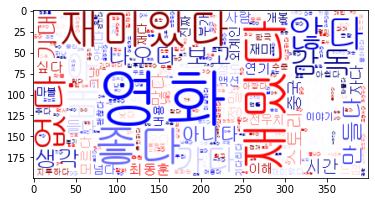

In [309]:
all_wc = generate_wc_frequencies(all_comment_word_count)
plt.imshow(all_wc, interpolation="bilinear")
plt.show()

#### 2-3-2. 긍정

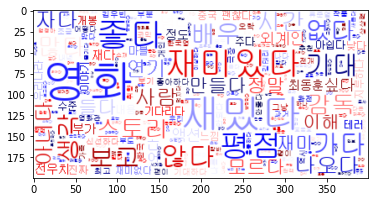

In [310]:
pos_wc = generate_wc_frequencies(pos_comment_word_count)
plt.imshow(pos_wc, interpolation="bilinear")
plt.show()

#### 2-3-3. 부정

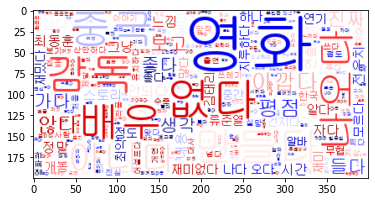

In [311]:
neg_wc = generate_wc_frequencies(neg_comment_word_count)
plt.imshow(neg_wc, interpolation="bilinear")
plt.show()

### 2-4 결과 해석

## 3. 분류기 학습시키기

#### 자주 쓰이는 함수

In [312]:
def load_data(file_path):
    train = []
    
    count = 0
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            if count == 500:
                break
                
            line = line.strip()
            id, doc, label = line.split('\t')
            if label == '1': 
                label = 'pos'
            elif label == '0': 
                label = 'neg'
            train.append((doc, label))
            count += 1
    return train

def format_data(reviews):
    train = []
    
    for review in reviews:
        comment = review[0].replace("\n", " ")
        if len(comment) > 140:
            continue
            
        rating = review[1]
        
        if rating >= POS:
            label = 'pos'
        elif rating <= NEG:
            label = 'neg'
        else:
            continue
        
        train.append((comment, label))
        
    return train

def pos_tokenize(raw_sent):
    pos_sent = []
    sent = okt.pos(raw_sent, norm=True, stem=True)
    for tup in sent:
        word, tag = tup[0], tup[1]
        word_tag = word + '/' + tag
        pos_sent.append(word_tag)
    return ' '.join(pos_sent)

def make_word_dict(train, use_morph=False):
    all_words = set()
    
    for tup in tqdm(train):
        sent, label = tup[0], tup[1]
        if use_morph:
            sent = pos_tokenize(sent)
        words = word_tokenize(sent)
        for word in words:
            all_words.add(word)
    return all_words

def make_train_feats(train, all_words, use_morph=False):
    train_features = []
    
    for tup in tqdm(train):
        sent, label = tup[0], tup[1]
        if use_morph:
            sent = pos_tokenize(sent)
        words = word_tokenize(sent)
        tmp = {set_word: (set_word in words) for set_word in all_words}
        sent_tup = (tmp, label)
        train_features.append(sent_tup)
    return train_features

In [313]:
train = format_data(reviews)

In [314]:
use_morph = True
all_words = make_word_dict(train, use_morph)
train_feature = make_train_feats(train, all_words, use_morph)

  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/1283 [00:00<?, ?it/s]

In [315]:
classifier = nltk.NaiveBayesClassifier.train(train_feature)
classifier.show_most_informative_features()

Most Informative Features
          재미있다/Adjective = True              pos : neg    =     30.0 : 1.0
                 최악/Noun = True              neg : pos    =     20.1 : 1.0
                 재다/Verb = True              pos : neg    =     15.9 : 1.0
                 점도/Noun = True              neg : pos    =     15.3 : 1.0
           재밌다/Adjective = True              pos : neg    =     14.4 : 1.0
                 부가/Noun = True              pos : neg    =     12.3 : 1.0
                7/Number = True              neg : pos    =     10.5 : 1.0
            낮다/Adjective = True              pos : neg    =     10.1 : 1.0
           아깝다/Adjective = True              neg : pos    =      9.8 : 1.0
                 테러/Noun = True              pos : neg    =      9.0 : 1.0


In [316]:
sents = load_data('ratings_test.txt')
for i in range(3, 500):
    test_sent = sents[i][0]
    comment = test_sent
    test_sent = pos_tokenize(test_sent)
    words = word_tokenize(test_sent)
    test_feature = {set_word: (set_word in words) for set_word in all_words}
    if i < 10:
        print(comment + ' ' + classifier.classify(test_feature))

뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아 neg
지루하지는 않은데 완전 막장임... 돈주고 보기에는.... pos
3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠?? pos
음악이 주가 된, 최고의 음악영화 pos
진정한 쓰레기 neg
마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다 neg
갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다 neg


In [318]:
test_sent = "100번 봐도 안 질릴 듯"
test_sent = pos_tokenize(test_sent)
words = word_tokenize(test_sent)
test_feature = {set_word: (set_word in words) for set_word in all_words}
print(classifier.classify(test_feature))

pos


In [319]:
nltk.classify.accuracy(classifier, train_features)

0.5406976744186046

# 자유주제

1. 내가 본 영화를 재밌게 본 사람의 다른 재밌는 영화
2. 다른 사이트와 비교